In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-t_b9f9er because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [3]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)

start_points = all_points[:,0,1:]
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

start_points = start_points - mean
poss = position_scaling
rts = rotation_scaling
start_points = (start_points * np.array((poss,poss,poss,rts,rts,rts,rts)))
start_points = start_points[:,3:]
print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 155 pickup attempts
std of:  0.17514298792733465
shape before reducing dimension (155, 64, 8)
dataset variance of: [0.00681216 0.0256     0.00585762 0.0066191 ]


In [4]:
dataset = start_points
dataset

array([[-2.04243148e-01,  5.44387289e-02,  3.84696722e-02,
         4.64175679e-02],
       [-6.70670201e-03, -5.80773918e-02, -4.14722813e-02,
        -7.55382064e-02],
       [-8.44968364e-02,  5.75544956e-02,  8.85519644e-03,
         4.29919450e-02],
       [-8.21906996e-02, -1.19511008e-01, -4.83304356e-02,
        -9.09107295e-02],
       [-4.84258704e-02, -5.71384591e-03, -1.77492202e-02,
        -7.46393964e-02],
       [ 2.13950858e-04, -2.58649568e-02, -3.80631354e-02,
         3.26658284e-02],
       [-1.31773248e-01,  1.23210198e-02, -2.45692139e-03,
         3.41239996e-02],
       [-8.93239645e-02,  8.83333377e-03, -1.27540891e-02,
         5.09409069e-02],
       [-1.37128783e-01,  1.08804010e-02,  1.69324826e-02,
        -1.36178613e-01],
       [-1.52826818e-01, -8.38714294e-03, -1.91882110e-03,
        -4.39923300e-02],
       [ 7.41052284e-02, -1.50087170e-02, -3.06132794e-02,
        -5.83673945e-02],
       [ 7.11915368e-02, -1.33119529e-01, -7.18239021e-02,
      

In [5]:
test_indices = np.arange(1,len(dataset),2)
train_indices = [i for i in range(len(dataset)) if i not in test_indices]
train_dataset=dataset[train_indices]
test_dataset=dataset[test_indices]

<IPython.core.display.Javascript object>


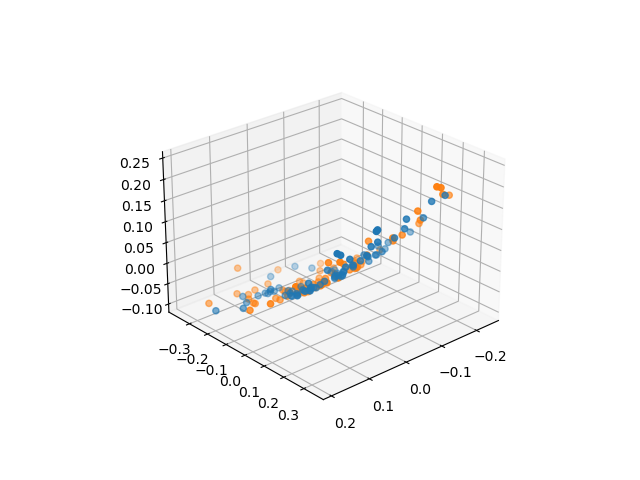

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(train_dataset[:,0],train_dataset[:,1],train_dataset[:,2]);
ax.scatter(test_dataset[:,0],test_dataset[:,1],test_dataset[:,2]);

## 2D VAE Fit to Dataset

In [7]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [8]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cpu"
  

In [9]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [10]:
def train_and_apply_pca_model(latent_dim, train_data, test_data):
    latentdim = latent_dim
    train_dataset_mean =  np.mean(train_data,axis=0)
    u,s,vt = np.linalg.svd(train_data-train_dataset_mean)
    trainmodeleduats = (train_data-train_dataset_mean) @ vt[:latentdim,:].T
    recon = trainmodeleduats @ vt[:latentdim,:] + train_dataset_mean
    testmodeleduats = (test_data-train_dataset_mean) @ vt[:latentdim,:].T
    testrecon = testmodeleduats @ vt[:latentdim,:] + train_dataset_mean
    error = recon - train_data
    testerror = testrecon  - test_data
    trainrmse = np.sqrt(np.mean(np.sum(np.square(error),axis=1)))
    testrmse = np.sqrt(np.mean(np.sum(np.square(testerror),axis=1)))
    return (trainrmse, testrmse)

In [11]:
train_and_apply_pca_model(2,train_dataset,test_dataset)

(0.07679927737019561, 0.08860254038216286)

In [12]:
train_and_apply_pca_model(1,train_dataset,test_dataset)

(0.10888774584271176, 0.1211599166895588)

In [16]:
train_and_apply_pca_model(0,train_dataset,test_dataset)

(0.20822807945957103, 0.21644116812443054)

In [13]:
latentdim = 2
train_dataset_mean =  np.mean(train_dataset,axis=0)
u,s,vt = np.linalg.svd(train_dataset-train_dataset_mean)
recon = u[:,:latentdim] @ np.diag(s[:latentdim]) @ vt[:latentdim,:]
error = recon + train_dataset_mean - train_dataset
print(np.sqrt(np.mean(np.sum(np.square(error),axis=1))))

0.07679927737019561


In [14]:
# train a CurvVAE model with given beta and gamma and return
# the string name of the saved model
def train_pca_model(beta,gamma,lr,epochs,latentdim,testname,train_dataset,test_dataset,device="cpu"):
    vae = make_vae(latent_dim=latentdim).to(device)
    num_epochs = epochs
    epsilon_scale_start = 0.5
    epsilon_scale = epsilon_scale_start
    savedir  = f'{testname}lat{latentdim}_lr{lr}_gamma{gamma}_es{epsilon_scale_start}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
    print(savedir)
    train_loader = Loader(train_dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
        log_dir=savedir, lr=lr, annealingBatches=0, record_loss_every=200, loss_func = "gaussian")
    epoch = 0
    traintesterrors = []
    for _ in range(num_epochs*3):
        epoch+=1
        # up num sample points to reduce variance of curvature measure
        embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=gamma, epsilon_scale = epsilon_scale, num_new_samp_points=512)
        is_error = embst[0]
        if is_error:
            raise Exception
        if epoch % 50 == 0:
            traintesterrors.append((epoch,error(vae,train_dataset),error(vae,test_dataset)))
    sm.save_fcpassthrough_vae(vae, savedir)
    print(savedir)
    return savedir,traintesterrors

In [15]:
test_dataset.shape

(77, 4)